In [ ]:
import os

base_path = "/content/ECB_project"

folders = [
    "data/raw_html",
    "data/raw_text",
    "data/processed",
    "src",
    "logs"
]

for folder in folders:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)


In [ ]:
!pip install requests beautifulsoup4 pandas

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

In [ ]:
# scrape_ecb_urls.py
# Robust (no selenium here):
#   1) requests main archive page
#   2) extract yearly snippet URLs from data-snippets
#   3) requests each snippet page and collect statement links
#   4) fetch each statement page -> meeting_date + title
# Output: ecb_urls_dates.csv with columns [meeting_date, url, title]
# ------------------------------------------------------------

import re
import time
from urllib.parse import urljoin, urlparse

import requests
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

BASE = "https://www.ecb.europa.eu"
INDEX_URL = "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/html/index.en.html"
HEADERS = {"User-Agent": "Mozilla/5.0"}

def parse_date_from_is_url(url: str) -> str | None:
    """
    Supports:
      .../html/is000203.en.html
      .../html/is030508_1.en.html
      .../html/ecb.is251218~hash.en.html
    """
    m = re.search(r"(?:/|\.)(?:ecb\.)?is(\d{2})(\d{2})(\d{2})(?:[_~].*)?\.en\.html$", url)
    if not m:
        return None
    yy, mm, dd = map(int, m.groups())
    year = 1900 + yy if yy >= 90 else 2000 + yy
    return f"{year:04d}-{mm:02d}-{dd:02d}"

def is_ecb_domain(url: str) -> bool:
    p = urlparse(url)
    return (p.netloc == "" or p.netloc.endswith("ecb.europa.eu"))

def fetch_soup(url: str) -> BeautifulSoup:
    r = requests.get(url, headers=HEADERS, timeout=40)
    r.raise_for_status()
    return BeautifulSoup(r.content, "html.parser")

def extract_title(soup: BeautifulSoup) -> str | None:
    """
    Prefer og:title (usually clean), then <title>, then first <h1>.
    """
    og = soup.find("meta", {"property": "og:title"})
    if og and og.get("content"):
        return og["content"].strip()

    t = soup.find("title")
    if t and t.get_text(strip=True):
        return t.get_text(strip=True)

    h1 = soup.find("h1")
    if h1 and h1.get_text(strip=True):
        return h1.get_text(strip=True)

    return None

def url_priority(u: str) -> int:
    """
    Lower score = preferred.
    Heuristics to pick the 'canonical' page if multiple URLs share the same date.
    """
    score = 0
    if "~" in u:            # hash urls often duplicates
        score += 10
    if re.search(r"_\d+\.en\.html$", u):  # isYYMMDD_1.en.html etc.
        score += 5
    if "ecb.is" in u:       # newer hashed patterns
        score += 3
    return score

def main():
    print("Fetching index page…", flush=True)
    index_soup = fetch_soup(INDEX_URL)

    dl = index_soup.find("dl", id="lazyload-container")
    if dl is None or not dl.has_attr("data-snippets"):
        raise RuntimeError("Could not find data-snippets on the index page.")

    snippets_raw = dl["data-snippets"]
    snippet_paths = [s.strip() for s in snippets_raw.split(",") if s.strip()]
    snippet_urls = [urljoin(INDEX_URL, p) for p in snippet_paths]

    # keep only 1999+
    snippet_urls_1999 = []
    for u in snippet_urls:
        m = re.search(r"/(\d{4})/html/index_include\.en\.html$", u)
        if m and int(m.group(1)) >= 1999:
            snippet_urls_1999.append(u)

    print(f"Keeping {len(snippet_urls_1999)} snippet pages for 1999+.", flush=True)

    all_statement_urls = set()

    for u in tqdm(snippet_urls_1999, desc="Downloading snippet pages"):
        try:
            soup = fetch_soup(u)

            for a in soup.find_all("a", href=True):
                href = a["href"].strip()
                full = urljoin(BASE, href)

                if not is_ecb_domain(full):
                    continue
                if "/press/press_conference/monetary-policy-statement/" not in full:
                    continue
                if not full.endswith(".en.html"):
                    continue

                all_statement_urls.add(full)

        except Exception as e:
            print(f"\nFailed snippet: {u} | {e}", flush=True)

        time.sleep(0.05)

    all_statement_urls = sorted(all_statement_urls)
    print(f"\nCollected {len(all_statement_urls)} statement URLs (1999+ snippets).", flush=True)

    df = pd.DataFrame({"url": all_statement_urls})

    meeting_dates = []
    titles = []

    for url in tqdm(df["url"], desc="Extracting dates + titles"):
        date = None
        title = None

        try:
            page = fetch_soup(url)

            # date: meta published_time if available
            meta = page.find("meta", {"property": "article:published_time"})
            if meta and meta.get("content"):
                dt = pd.to_datetime(meta["content"], errors="coerce")
                if pd.notna(dt):
                    date = dt.strftime("%Y-%m-%d")

            # title
            title = extract_title(page)

        except Exception:
            pass

        if not date:
            date = parse_date_from_is_url(url)

        meeting_dates.append(date)
        titles.append(title)

        time.sleep(0.05)

    df["meeting_date"] = meeting_dates
    df["title"] = titles

    # keep 1999+
    out = df.dropna(subset=["meeting_date"]).copy()
    out = out[out["meeting_date"] >= "1999-01-01"].copy()

    # choose ONE row per date
    out["prio"] = out["url"].apply(url_priority)
    out = (
        out.sort_values(["meeting_date", "prio", "url"])
           .drop_duplicates(subset=["meeting_date"], keep="first")
           .drop(columns=["prio"])
           .sort_values("meeting_date")
           .reset_index(drop=True)
    )

    out_path = "ecb_urls_dates.csv"
    out[["meeting_date", "url", "title"]].to_csv(out_path, index=False)

    print("\nSaved:", out_path, flush=True)
    print("Rows:", len(out), flush=True)
    if len(out):
        print("Earliest:", out["meeting_date"].iloc[0], flush=True)
        print("Latest:", out["meeting_date"].iloc[-1], flush=True)

if __name__ == "__main__":
    main()


Fetching index page…
Keeping 27 snippet pages for 1999+.



Collected 285 statement URLs (1999+ snippets).



Extracting dates + titles: 100%|██████████| 285/285 [02:33<00:00,  1.86it/s]


Saved: ecb_urls_dates.csv
Rows: 282
Earliest: 1999-01-07
Latest: 2025-12-18


In [ ]:
import pandas as pd

df = pd.read_csv("ecb_urls_dates.csv")

df["meeting_date"] = df["meeting_date"].astype(str).str.strip()

df["meeting_date"] = pd.to_datetime(
    df["meeting_date"],
    errors="coerce",
    dayfirst=True,
    format="mixed"
)

print("Unparsed rows:", df["meeting_date"].isna().sum())


Unparsed rows: 0


In [ ]:
df["title_lower"] = df["title"].astype(str).str.lower()

keep_pattern = r"(introductory statement|monetary policy statement)"
drop_pattern = r"(transcript|opening|signing|agreement|exhibition|balance of payments|design|assessment)"

df_clean = df[
    df["title_lower"].str.contains(keep_pattern, regex=True, na=False) &
    ~df["title_lower"].str.contains(drop_pattern, regex=True, na=False)
].copy()


/tmp/ipython-input-2378790882.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["title_lower"].str.contains(keep_pattern, regex=True, na=False) &
/tmp/ipython-input-2378790882.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ~df["title_lower"].str.contains(drop_pattern, regex=True, na=False)


In [ ]:
df_clean = (
    df_clean.sort_values(["meeting_date", "url"])
            .drop_duplicates(subset=["meeting_date"], keep="first")
            .reset_index(drop=True)
)


In [ ]:
print("Total meetings:", len(df_clean))
print(df_clean.groupby(df_clean["meeting_date"].dt.year).size())


Total meetings: 274
meeting_date
1999    11
2000    13
2001    11
2002    11
2003    12
2004    11
2005    11
2006    12
2007    11
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015     8
2016     8
2017     7
2018     8
2019     8
2020     8
2021     8
2022     8
2023     8
2024     8
2025     8
dtype: int64


In [ ]:
df_clean[["meeting_date","url","title"]].to_csv(
    "ecb_monetary_policy_statements_all_years.csv",
    index=False
)


In [ ]:
import re
import csv
import pandas as pd
import requests
from bs4 import BeautifulSoup

HEADERS = {"User-Agent": "Mozilla/5.0"}

JUNK_LINE_RE = re.compile(
    r"(?im)^\s*(jump to the transcript of the questions and answers|with the transcript of the questions and answers)\s*$"
)

TRANSCRIPT_START_RE = re.compile(r"(?im)^\s*transcript of the questions.*$")
QNA_HEADING_RE = re.compile(r"(?im)^\s*(questions and answers|q\s*&\s*a|q&a)\s*$")
QUESTION_PREFIX_RE = re.compile(r"(?im)^\s*question\s*:")

SPOKEN_MARKERS = [
    "we are now ready to take your questions",
    "we are now ready for your questions",
    "we are now at your disposal for questions",
    "i will now take your questions",
]

def download_html(url: str) -> str:
    r = requests.get(url, headers=HEADERS, timeout=40)
    r.raise_for_status()
    r.encoding = r.apparent_encoding
    return r.text

def extract_title(soup: BeautifulSoup) -> str:
    h1 = soup.find("h1")
    if h1 and h1.get_text(strip=True):
        return h1.get_text(" ", strip=True)
    if soup.title and soup.title.get_text(strip=True):
        return soup.title.get_text(" ", strip=True)
    return ""

def extract_main_text(soup: BeautifulSoup) -> str:
    main = soup.find("main")
    article = main.find("article") if main else None
    node = article or main or soup.body or soup

    for tag in node.find_all(["script", "style", "nav", "header", "footer", "aside"]):
        tag.decompose()

    text = node.get_text(separator="\n")
    text = re.sub(r"\r", "\n", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def remove_junk_lines(text: str) -> str:
    lines = text.split("\n")
    lines = [ln for ln in lines if not JUNK_LINE_RE.match(ln.strip())]
    return "\n".join(lines).strip()

def split_statement_qna_whole(text: str):
    text = remove_junk_lines(text)
    lines = text.split("\n")

    def find_line_index(pattern_re):
        for i, ln in enumerate(lines):
            if pattern_re.match(ln.strip()):
                return i
        return None

    i = find_line_index(TRANSCRIPT_START_RE)
    if i is not None:
        return "\n".join(lines[:i]).strip(), "\n".join(lines[i:]).strip()

    i = find_line_index(QNA_HEADING_RE)
    if i is not None:
        return "\n".join(lines[:i]).strip(), "\n".join(lines[i:]).strip()

    i = find_line_index(QUESTION_PREFIX_RE)
    if i is not None:
        return "\n".join(lines[:i]).strip(), "\n".join(lines[i:]).strip()

    low = text.lower()
    for m in SPOKEN_MARKERS:
        idx = low.find(m)
        if idx != -1:
            return text[:idx].strip(), text[idx:].strip()

    return text.strip(), ""

def scrape_one(url: str):
    html = download_html(url)
    soup = BeautifulSoup(html, "html.parser")

    title = extract_title(soup)
    main_text = extract_main_text(soup)
    statement, qa = split_statement_qna_whole(main_text)

    return title, statement, qa

def excel_safe_multiline(s: str) -> str:
    """
    Replace real newlines inside a cell with the literal characters \n
    so Excel doesn't display them as extra rows when opening CSV.
    """
    if s is None:
        return ""
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    return s.replace("\n", r"\n")

def scrape_statements():
    url_index_path = "ecb_monetary_policy_statements_all_years.csv"
    df = pd.read_csv(url_index_path)

    if "meeting_date" not in df.columns or "url" not in df.columns:
        raise ValueError("Your driver CSV must have columns: meeting_date, url")

    out = []
    for _, row in df.iterrows():
        meeting_date = str(row["meeting_date"])[:10]
        url = row["url"]

        try:
            title, statement, qa = scrape_one(url)
        except Exception as e:
            print(f"[FAIL] {meeting_date} {url} -> {e}")
            title = statement = qa = ""

        out.append({
            "meeting_date": meeting_date,
            "url": url,
            "title": title,
            "statement_text": excel_safe_multiline(statement),
            "qa_text": excel_safe_multiline(qa),
        })

    out_df = pd.DataFrame(out)

    # IMPORTANT: quote all fields so Excel behaves better
    out_df.to_csv(
        "ecb_statement_qna_raw.csv",
        index=False,
        quoting=csv.QUOTE_ALL
    )

    print("Saved: ecb_statement_qna_raw.csv")
    print("Rows:", len(out_df))

if __name__ == "__main__":
    scrape_statements()


Saved: ecb_statement_qna_raw.csv
Rows: 274


In [ ]:
import pandas as pd
import re

# load raw CSV
df = pd.read_csv("ecb_statement_qna_raw.csv", dtype=str)

# turn literal \n back into real newlines
for col in ["statement_text", "qa_text"]:
    df[col] = df[col].fillna("").str.replace(r"\n", "\n", regex=False)

# --- STATEMENT CLEANING ---
def clean_statement(s):
    lines = [ln.strip() for ln in s.split("\n") if ln.strip()]

    drop_re = re.compile(
        r"^(ecb|european central bank).*press conference$|"
        r"^monetary policy statement$|"
        r"^introductory statement$",
        re.I
    )

    while lines and drop_re.match(lines[0]):
        lines.pop(0)

    return "\n".join(lines)

# --- Q&A CLEANING ---
def clean_qa(q):
    lines = [ln.strip() for ln in q.split("\n") if ln.strip()]

    lines = [
        ln for ln in lines
        if not re.match(r"^transcript of the questions", ln, re.I)
    ]

    return "\n".join(lines)

df["statement_text_clean"] = df["statement_text"].apply(clean_statement)
df["qa_text_clean"] = df["qa_text"].apply(clean_qa)

# make CSV-safe again
for col in ["statement_text_clean", "qa_text_clean"]:
    df[col] = df[col].str.replace("\n", r"\n", regex=False)

# export to CSV
df.to_csv("ecb_statement_qna_cleaned.csv", index=False)

print("Saved: ecb_statement_qna_cleaned.csv")
print("Rows:", len(df))


Saved: ecb_statement_qna_cleaned.csv
Rows: 274


Tokenisation (texte → mots propres)

In [ ]:
# Step 1.0 — Prepare dates and sort

import pandas as pd

df = df.copy()

# FIX: create date from meeting_date (this column exists)
df["date"] = pd.to_datetime(df["meeting_date"], errors="coerce")

df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

print("Date range:", df["date"].min(), "→", df["date"].max())
df[["date"]].head()


Date range: 1999-01-07 00:00:00 → 2025-12-18 00:00:00


,date
0,1999-01-07
1,1999-02-04
2,1999-03-04
3,1999-04-08
4,1999-05-06


In [ ]:
# Step 1.1 — Tokenize text (stopwords + Porter stemming)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

nltk.download("stopwords")

STOP_WORDS = set(stopwords.words("english"))
tokenizer = RegexpTokenizer(r"[a-zA-Z]+")
stemmer = PorterStemmer()

def tokenize(text: str):
    if pd.isna(text):
        return []
    tokens = tokenizer.tokenize(str(text).lower())
    tokens = [stemmer.stem(t) for t in tokens if t not in STOP_WORDS]
    return tokens

print(tokenize(df.loc[0, "statement_text_clean"])[:30])


['ecb', 'press', 'confer', 'introductori', 'statement', 'nwillem', 'f', 'duisenberg', 'presid', 'european', 'central', 'bank', 'thursday', 'januari', 'nladi', 'gentlemen', 'vice', 'presid', 'today', 'report', 'outcom', 'first', 'meet', 'govern', 'council', 'european', 'central', 'bank', 'stage', 'three']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Step 1.2 — Build bigram sets (paper-faithful, no double processing)

from nltk.util import bigrams

def bigram_set(text: str):
    """
    Convert text -> tokens -> set of bigrams
    Uses tokenize() from Step 1.1 (stopwords + Porter stem) exactly once.
    """
    tokens = tokenize(text)
    if len(tokens) < 2:
        return set()
    return set(bigrams(tokens))

# Quick test
print(list(bigram_set(df.loc[0, "statement_text_clean"]))[:10])


[('signific', 'upward'), ('euro', 'n'), ('price', 'balanc'), ('report', 'overal'), ('council', 'therefor'), ('import', 'produc'), ('norder', 'book'), ('regard', 'outlook'), ('normal', 'oper'), ('continu', 'care')]


In [ ]:
# Step 1.3 — Jaccard similarity

def jaccard(A: set, B: set) -> float:
    if not A or not B:
        return 0.0
    return len(A & B) / len(A | B)

# Quick test
A = {("ecb","press"), ("press","conference")}
B = {("ecb","press"), ("central","bank")}
print(jaccard(A, B))  # expected: 1 / 3 = 0.333...


0.3333333333333333


In [ ]:
# Step 1.35 — Sanity check before splitting samples

required_cols = ["date", "statement_text_clean", "qa_text_clean"]
missing = [c for c in required_cols if c not in df.columns]

print("Missing columns:", missing)
print("df shape:", df.shape)

# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")
print("date min/max:", df["date"].min(), "→", df["date"].max())
print("NaT dates:", df["date"].isna().sum())

# Sort
df = df.sort_values("date").reset_index(drop=True)
df.head(3)


Missing columns: []
df shape: (274, 10)
date min/max: 1999-01-07 00:00:00 → 2025-12-18 00:00:00
NaT dates: 0


,meeting_date,url,title,statement_text,qa_text,statement_text_clean,qa_text_clean,date,statement_similarity,qa_similarity
0,1999-01-07,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ECB Press conference: Introductory statement\n...,Transcript of the questions asked and the answ...,ECB Press conference: Introductory statement\n...,Question:\nThe teething problems that you ment...,1999-01-07,<NA>,<NA>
1,1999-02-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ECB Press conference: Introductory statement\n...,Transcript of the questions asked and the answ...,ECB Press conference: Introductory statement\n...,Question:\n... this extension of the period of...,1999-02-04,0.12491,0.034991
2,1999-03-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ECB Press conference: Introductory statement\n...,Transcript of the questions asked and the answ...,ECB Press conference: Introductory statement\n...,"Question (translation)\n: Mr. President, what,...",1999-03-04,0.157895,0.035145


In [ ]:
# Check if bigram-set columns already exist
print("bigrams_statement in df ?", "bigrams_statement" in df.columns)
print("bigrams_qa in df ?", "bigrams_qa" in df.columns)


bigrams_statement in df ? False
bigrams_qa in df ? False


In [ ]:
# Build bigram sets (only if missing)
if "bigrams_statement" not in df.columns:
    df["bigrams_statement"] = df["statement_text_clean"].apply(bigram_set)

if "bigrams_qa" not in df.columns:
    df["bigrams_qa"] = df["qa_text_clean"].apply(bigram_set)

df[["date", "bigrams_statement", "bigrams_qa"]].head(2)


,date,bigrams_statement,bigrams_qa
0,1999-01-07,"{(signific, upward), (euro, n), (price, balanc...","{(nwe, discuss), (question, second), (eas, hap..."
1,1999-02-04,"{(signific, upward), (therefor, support), (nin...","{(togeth, much), (system, settl), (nwe, discus..."


In [ ]:
# Step 1.37 — Split samples (Replication vs Extension)

df_all = df.sort_values("date").reset_index(drop=True).copy()

df_9913 = df_all[(df_all["date"] >= "1999-01-01") & (df_all["date"] <= "2013-12-31")].copy()
df_9925 = df_all[(df_all["date"] >= "1999-01-01") & (df_all["date"] <= "2025-12-31")].copy()

print("Replication sample 1999–2013:", df_9913["date"].min(), "→", df_9913["date"].max(), "| n =", len(df_9913))
print("Extension sample 1999–2025:", df_9925["date"].min(), "→", df_9925["date"].max(), "| n =", len(df_9925))


Replication sample 1999–2013: 1999-01-07 00:00:00 → 2013-12-05 00:00:00 | n = 175
Extension sample 1999–2025: 1999-01-07 00:00:00 → 2025-12-18 00:00:00 | n = 274


In [ ]:
# Quick check: unique dates (should be True)
print("9913 unique dates:", df_9913["date"].is_unique)
print("9925 unique dates:", df_9925["date"].is_unique)


9913 unique dates: True
9925 unique dates: True


Apply the similarity function separately to each sample
to avoid look-ahead bias and ensure a strict replication


In [ ]:
# Step 1.38 — Compute similarity series within a sample

import pandas as pd

def compute_similarity_series_from_sets(sets_series):
    """
    Compute Jaccard similarity between consecutive documents
    within a given sample.
    """
    similarities = [pd.NA]  # first document has no previous one
    for i in range(1, len(sets_series)):
        prev_set = sets_series.iloc[i-1]
        curr_set = sets_series.iloc[i]

        if prev_set is None or curr_set is None:
            similarities.append(pd.NA)
        elif len(prev_set) == 0 and len(curr_set) == 0:
            similarities.append(pd.NA)
        else:
            similarities.append(jaccard(prev_set, curr_set))

    return similarities


In [ ]:
# Step 1.39 — Replication sample (1999–2013): statement similarity

df_9913 = df_9913.sort_values("date").reset_index(drop=True)

df_9913["statement_similarity"] = compute_similarity_series_from_sets(
    df_9913["bigrams_statement"]
)

# Quick view (first 10 rows)
df_9913[["date", "statement_similarity"]].head(10)


,date,statement_similarity
0,1999-01-07,<NA>
1,1999-02-04,0.12491
2,1999-03-04,0.157895
3,1999-04-08,0.09764
4,1999-05-06,0.103343
5,1999-06-02,0.147335
6,1999-07-15,0.100071
7,1999-09-09,0.085427
8,1999-10-07,0.106396
9,1999-11-04,0.099407


In [ ]:
df_9913["statement_similarity"].dropna().describe()


,statement_similarity
count,174.00000
unique,174.00000
top,0.12491
freq,1.00000


In [ ]:
# Force similarity column to numeric (important for stats & regressions)

df_9913["statement_similarity"] = pd.to_numeric(
    df_9913["statement_similarity"], errors="coerce"
)

df_9913["statement_similarity"].describe()


,statement_similarity
count,174.000000
mean,0.242567
std,0.124607
min,0.007338
25%,0.136924
50%,0.224145
75%,0.342385
max,0.549451


In [ ]:
# Step 1.40 — Extension sample (1999–2025): statement similarity

df_9925 = df_9925.sort_values("date").reset_index(drop=True)

df_9925["statement_similarity"] = compute_similarity_series_from_sets(
    df_9925["bigrams_statement"]
)

df_9925["statement_similarity"] = pd.to_numeric(
    df_9925["statement_similarity"], errors="coerce"
)

df_9925["statement_similarity"].describe()


,statement_similarity
count,273.000000
mean,0.291403
std,0.141434
min,0.007338
25%,0.168390
50%,0.296355
75%,0.396104
max,0.641457


“Extending the sample to 2025, we find that the average similarity of ECB introductory statements increases from 0.24 in the replication period (1999–2013) to 0.29, suggesting a continued standardization of ECB communication beyond the original sample.”

#Q&A similarity (1999–2013)

In [ ]:
# Step 1.41 — Replication sample (1999–2013): Q&A similarity

df_9913["qa_similarity"] = compute_similarity_series_from_sets(
    df_9913["bigrams_qa"]
)

df_9913["qa_similarity"] = pd.to_numeric(
    df_9913["qa_similarity"], errors="coerce"
)

df_9913["qa_similarity"].describe()


,qa_similarity
count,174.000000
mean,0.042419
std,0.007341
min,0.000000
25%,0.039087
50%,0.043388
75%,0.046843
max,0.055637


“While ECB introductory statements exhibit substantial textual continuity, Q&A sessions remain much more heterogeneous, reflecting their interactive and less scripted nature.”

#Q&A similarity (1999–2025)

In [ ]:
# Step 1.42 — Extension sample (1999–2025): Q&A similarity

df_9925["qa_similarity"] = compute_similarity_series_from_sets(
    df_9925["bigrams_qa"]
)

df_9925["qa_similarity"] = pd.to_numeric(
    df_9925["qa_similarity"], errors="coerce"
)

df_9925["qa_similarity"].describe()


,qa_similarity
count,273.000000
mean,0.042569
std,0.007674
min,0.000000
25%,0.039335
50%,0.043430
75%,0.047215
max,0.058973


In contrast, the similarity of Q&A sessions remains very low (around 0.04) and stable over time, highlighting the inherently heterogeneous and interactive nature of this communication channel.

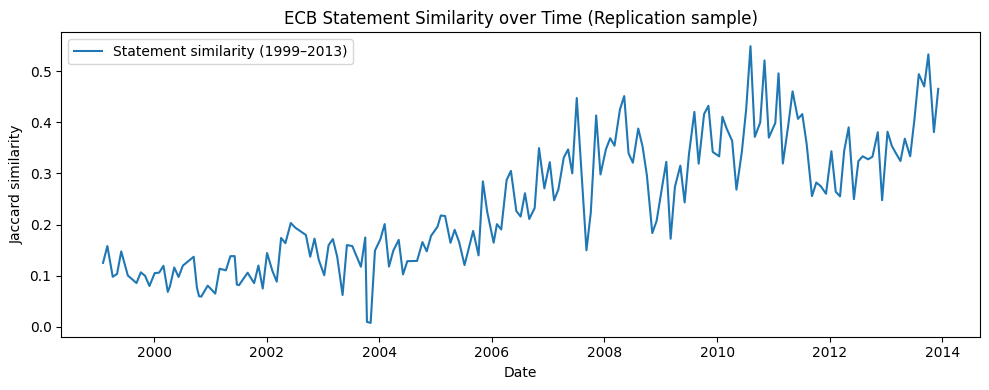

In [ ]:
import matplotlib.pyplot as plt

# Plot statement similarity over time — Replication sample (1999–2013)
plt.figure(figsize=(10,4))
plt.plot(df_9913["date"], df_9913["statement_similarity"], label="Statement similarity (1999–2013)")
plt.xlabel("Date")
plt.ylabel("Jaccard similarity")
plt.title("ECB Statement Similarity over Time (Replication sample)")
plt.legend()
plt.tight_layout()
plt.show()


The upward trend in statement similarity suggests an increasing standardization of ECB communication, consistent with the learning hypothesis emphasized by Amaya and Filbien (2015).

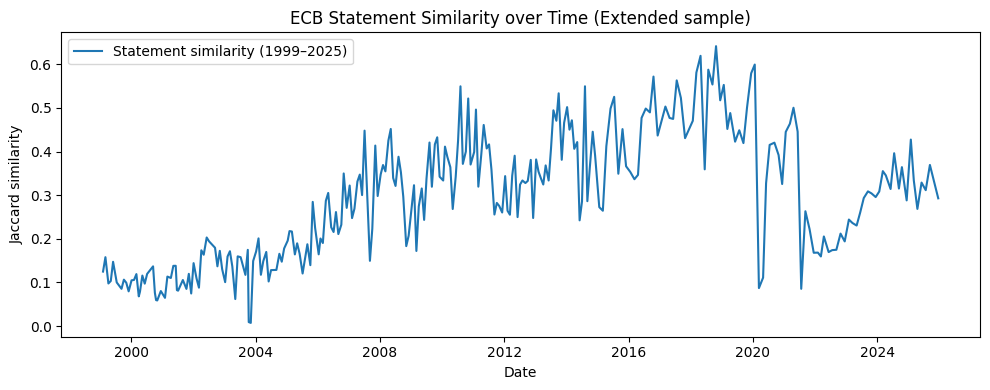

In [ ]:
# Plot statement similarity over time — Extension sample (1999–2025)

plt.figure(figsize=(10,4))
plt.plot(df_9925["date"], df_9925["statement_similarity"], label="Statement similarity (1999–2025)")
plt.xlabel("Date")
plt.ylabel("Jaccard similarity")
plt.title("ECB Statement Similarity over Time (Extended sample)")
plt.legend()
plt.tight_layout()
plt.show()


While statement similarity increases steadily until the mid-2010s, we observe a sharp drop around 2020, consistent with the unprecedented nature of the COVID-19 shock. Post-2020, similarity partially recovers but remains below pre-crisis levels, suggesting a more adaptive communication strategy

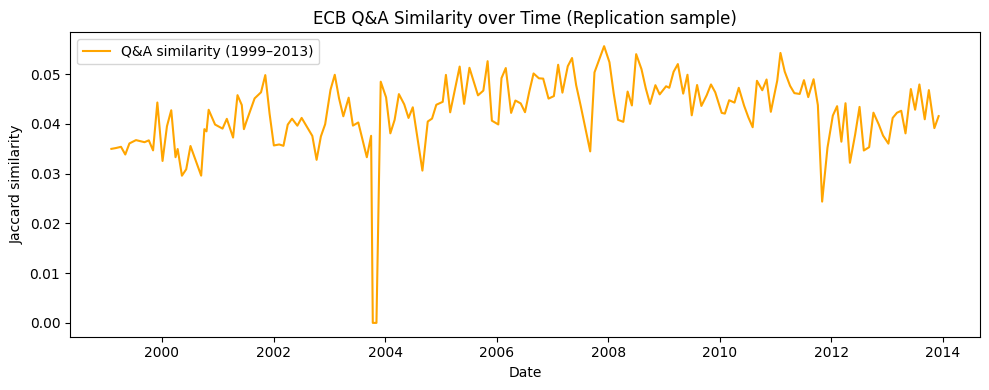

In [ ]:
# Plot Q&A similarity over time — Replication sample (1999–2013)

plt.figure(figsize=(10,4))
plt.plot(df_9913["date"], df_9913["qa_similarity"], label="Q&A similarity (1999–2013)", color="orange")
plt.xlabel("Date")
plt.ylabel("Jaccard similarity")
plt.title("ECB Q&A Similarity over Time (Replication sample)")
plt.legend()
plt.tight_layout()
plt.show()


Unlike introductory statements, Q&A sessions exhibit low and stable similarity, reflecting their interactive and unscripted nature

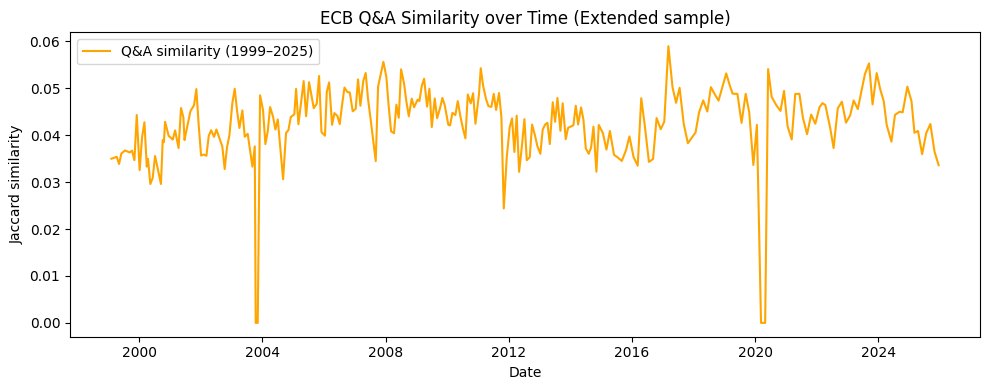

In [ ]:
# Plot Q&A similarity over time — Extension sample (1999–2025)

plt.figure(figsize=(10,4))
plt.plot(df_9925["date"], df_9925["qa_similarity"], label="Q&A similarity (1999–2025)", color="orange")
plt.xlabel("Date")
plt.ylabel("Jaccard similarity")
plt.title("ECB Q&A Similarity over Time (Extended sample)")
plt.legend()
plt.tight_layout()
plt.show()


While the similarity of ECB introductory statements increases markedly over time, the similarity of Q&A sessions remains low and stable even in the extended sample, confirming the fundamentally interactive nature of this communication channel.

/tmp/ipython-input-3485360494.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


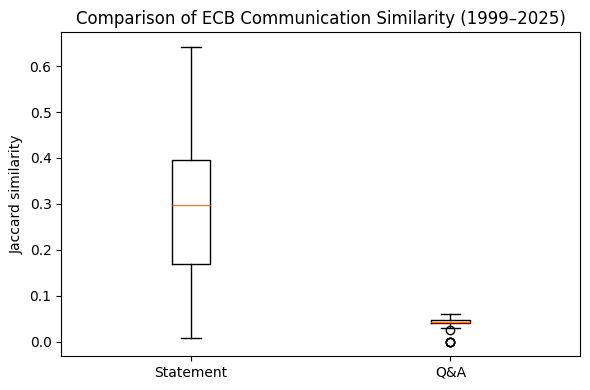

In [ ]:
# Boxplot comparison: Statement vs Q&A similarity (1999–2025)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.boxplot(
    [
        df_9925["statement_similarity"].dropna(),
        df_9925["qa_similarity"].dropna()
    ],
    labels=["Statement", "Q&A"],
    showfliers=True
)

plt.ylabel("Jaccard similarity")
plt.title("Comparison of ECB Communication Similarity (1999–2025)")
plt.tight_layout()
plt.show()


### Summary of similarity analysis

We find strong evidence of increasing standardization in ECB introductory statements, both in the original sample and in the extended sample up to 2025. In contrast, Q&A sessions remain characterized by low and stable similarity over time, highlighting the fundamentally interactive nature of this communication channel.
